In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [8]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = './data/train_data.csv'
train_df = pd.read_csv('./data/train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv('./data/test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

df = pd.concat([train_df, test_df.loc[test_df['answerCode'] != -1]], axis=0)
df = df.sort_values(by=["userID", "Timestamp",]).reset_index(drop=True)


CPU times: user 6.82 s, sys: 548 ms, total: 7.36 s
Wall time: 7.37 s


In [5]:
print(f"""--- Train INFORMATIONS ---
userID           : {train_df.userID.nunique()}
assessmentItemID : {train_df.assessmentItemID.nunique()}
testID           : {train_df.testId.nunique()}
mean answer rate : {train_df.answerCode.sum() / train_df.shape[0] * 100:.2f}%
KnowledgeTag     : {train_df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


In [6]:
print(f"""--- Test INFORMATIONS ---
userID           : {test_df.userID.nunique()}
assessmentItemID : {test_df.assessmentItemID.nunique()}
testID           : {test_df.testId.nunique()}
mean answer rate : {test_df.answerCode.sum() / test_df.shape[0] * 100:.2f}%
KnowledgeTag     : {test_df.KnowledgeTag.nunique()}
{'-'*26}""")

--- Test INFORMATIONS ---
userID           : 744
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.22%
KnowledgeTag     : 912
--------------------------


train 유저 6698, test 유저 744

In [10]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [13]:
def cut(x):
    return [i[-3:] for i in x]

In [17]:
def att(x):
    a = []
    for i in x:
        a.extend(i)
    return sorted(set(a))

In [65]:
def percentile(s):
    return np.sum(s) / len(s)

## 유저가 푼 testId에 대한 문항들의 개수가 모두 같은지 확인 해 보기

In [56]:
usertest_Qs = train_df.groupby(['userID', 'testId']).agg({'assessmentItemID' : cut})
usertest_Qs['assessmentItemID'] = usertest_Qs['assessmentItemID'].apply(set).apply(sorted)
usertest_Qs.reset_index(inplace = True)
usertest_Qs

,userID,testId,assessmentItemID
0,0,A020000172,"[001, 002, 003, 004, 005, 006]"
1,0,A020000174,"[001, 002, 003, 004, 005]"
2,0,A020000181,"[001, 002, 003, 004, 005, 006]"
3,0,A020000182,"[001, 002, 003, 004, 005]"
4,0,A020000183,"[001, 002, 003, 004, 005, 006, 007]"
...,...,...,...
365159,7440,A030000136,"[001, 002, 003, 004, 005]"
365160,7440,A030000197,"[001, 002, 003, 004, 005]"
365161,7440,A050000096,"[001, 002, 003, 004, 005]"
365162,7441,A030000071,"[001, 002, 003, 004, 005]"


In [30]:
testid_Qs = usertest_Qs.groupby('testId').agg({'assessmentItemID': att})
testid_Qs

,assessmentItemID
testId,
A010000001,"[001, 002, 003, 004, 005]"
A010000002,"[001, 002, 003, 004, 005]"
A010000003,"[001, 002, 003, 004, 005]"
A010000004,"[001, 002, 003, 004, 005]"
A010000005,"[001, 002, 003, 004, 005]"
...,...
A090000070,"[001, 002, 003, 004, 005, 006, 007, 008]"
A090000071,"[001, 002, 003, 004, 005, 006, 007, 008]"
A090000072,"[001, 002, 003, 004, 005, 006]"


In [31]:
comp_u_t = pd.merge(usertest_Qs, testid_Qs, on='testId')
comp_u_t['comp'] = comp_u_t['assessmentItemID_x'] == comp_u_t['assessmentItemID_y']
comp_u_t

,userID,testId,assessmentItemID_x,assessmentItemID_y,comp
0,0,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
1,14,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
2,81,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
3,95,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
4,102,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
...,...,...,...,...,...
365159,4289,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365160,4965,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365161,5189,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365162,5472,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True


In [32]:
comp_u_t[comp_u_t['comp'] == False]

,userID,testId,assessmentItemID_x,assessmentItemID_y,comp


## TestId의 앞 세자리에 대해서

#### TestId의 앞 세자리는 KnowledgeTag와 관련이 있을까?

In [40]:
testknow = df
testknow['first3'] = testknow['testId'].map(lambda x: x[2])
testknow

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,first3
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4


In [41]:
testknow.first3.unique()

array(['6', '8', '2', '4', '9', '3', '5', '7', '1'], dtype=object)

In [48]:
testknow.KnowledgeTag.nunique()

912

In [61]:
def aa(x):
    return sorted(set(x))

In [70]:
testknow.groupby('first3').agg({'KnowledgeTag': aa})


,KnowledgeTag
first3,
1,"{7808, 7809, 7810, 7811, 7812, 7813, 7815, 679..."
2,"{7936, 7938, 7941, 7943, 7944, 7693, 7694, 782..."
3,"{7690, 7691, 547, 551, 554, 559, 574, 7781, 77..."
4,"{2048, 2049, 2050, 11265, 2053, 2054, 11269, 1..."
5,"{2615, 2616, 2617, 2618, 2619, 2620, 2621, 262..."
6,"{1548, 9232, 1531, 1533, 1575, 1576, 1577, 157..."
7,"{5653, 5654, 5655, 5656, 9765, 5808, 10819, 97..."
8,"{7170, 7171, 7172, 23, 24, 3097, 25, 26, 30, 3..."
9,"{9728, 10759, 10760, 10764, 10766, 9743, 9744,..."


### 앞 세자리와 정답률?

In [66]:
testknow.groupby('first3').agg({'answerCode': percentile})

,answerCode
first3,
1,0.801686
2,0.738023
3,0.702210
4,0.680256
5,0.659098
6,0.712279
7,0.521761
8,0.500826
9,0.454680


<AxesSubplot: xlabel='first3'>

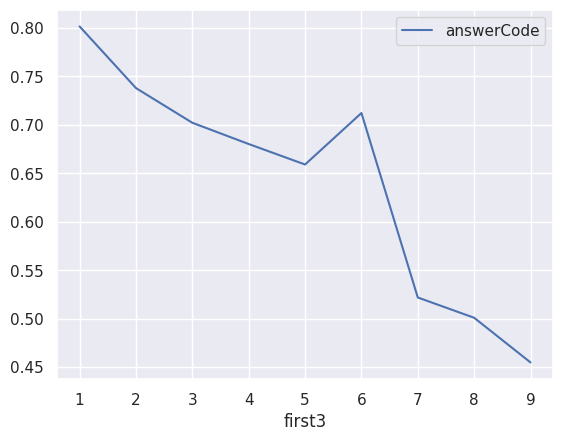

In [68]:
testknow.groupby('first3').agg({'answerCode': percentile}).plot()